# ASTR 310 HW10, Spring 2024

## 1. Additional work with FITS image files and Fourier Transforms

Write a program to read in the Large Magellanic Cloud FITS image file from lecture 18 and perform the following operations on it.  Plot the result as a new image after each step.  Extra hints are in Reading 21.

You will need to know the size of the pixels in order to do some of these steps.  Note that the XPIXSIZE and YPIXSIZE keywords in the file header are incorrect due to binning; instead, if you read the file with CCDdata.read, you can get the pixel sizes in degrees from img.wcs.wcs.cd[0][0] and img.wcs.wcs.cd[1][1].

**a)** Display the original image with a nice color stretch so that you can see structures within the galaxy.  Actual RA and Dec coordinates are most desirable for the axes.

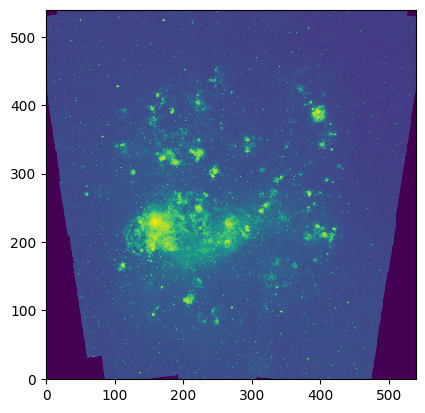

In [1]:
# Code here
from astropy.nddata import CCDData as CCD
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.wcs
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import SymLogNorm
lmc = fits.open('lmc.ha.b20.fits')
plt.imshow(np.log10(lmc[0].data+1e-8),norm=SymLogNorm(linthresh=.03, linscale=.03, vmin=-2.0, vmax=2.0),origin='lower')

**b)** Apply a Gaussian filter (smoothing) of width 1 degree to the original image and plot the smoothed version.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/11/1998' to '1998-11-21''. [astropy.wcs.wcs]


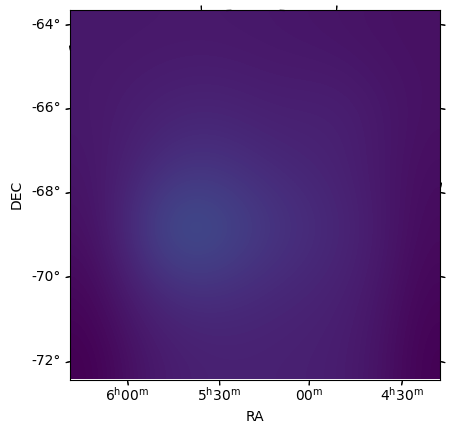

In [2]:
# Code here
lmc2 = CCD.read("lmc.ha.b20.fits",format="fits",unit="adu")
wcs = lmc2.wcs
XPIX = lmc2.wcs.wcs.cd[0][0]
YPIX = lmc2.wcs.wcs.cd[1][1]
from scipy import ndimage


width = 1/np.abs(XPIX)

smoothed = ndimage.gaussian_filter(lmc2,width)
plt.subplot(projection=wcs)
plt.xlabel("RA")
plt.ylabel("DEC")
plt.imshow(smoothed,origin='lower',vmax=5)


**c)** Convolve the original image with a boxcar filter of width 1 degree and plot that.

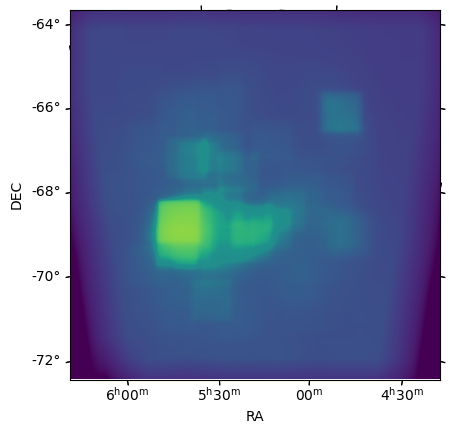

In [3]:
# Code here
from astropy.convolution import convolve, Box2DKernel, Gaussian2DKernel


boxy = convolve(lmc2,Box2DKernel(width))
plt.subplot(projection=wcs)
plt.xlabel("RA")
plt.ylabel("DEC")
plt.imshow(np.log10(boxy+1e-8),norm=SymLogNorm(linthresh=.03, linscale=.03, vmin=-2.0, vmax=2.0),origin='lower')



**d)** Fourier-transform the original image.  Pick two of your favorite integers $q$ and $w$ between 0 and 30, and at least one of them can't be zero.  If fhat contains your Fourier components, then set fhat[q,w] equal to something large such as 10 times the maximum in fhat.  Then do the inverse FT and plot the result.  You should see that a spike in the Fourier components corresponds to a sine wave across the image.

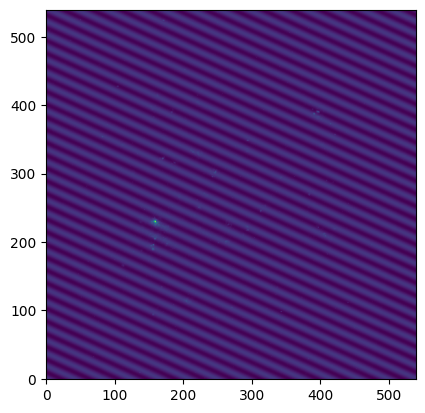

In [4]:
# Code here
fhat = np.fft.rfft2(lmc2.data)
fhat2 = fhat
fhat[29][13] = np.max(fhat)*10 
ifhat = np.fft.irfft2(fhat)
plt.imshow(ifhat,origin="lower")

**e)** Fourier-transform the original image and remove all the odd-numbered Fourier components.  In other words, set fhat[k,j] = 0 if either k or j is odd.  Transform back to real space and plot the result.  Can you explain what happened to the image?  As a hint, you might go back to the previous part and experiment with putting your spike at fhat[0,1] or [0,3] or [1,0] to find out what the removed components look like.

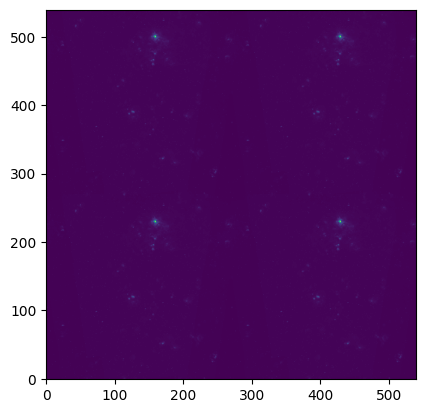

In [5]:
# Code here
fhat = fhat2
for k in range(fhat.shape[0]):
    for j in range(fhat.shape[1]):
        if k%2!=0 or j%2!=0:
            fhat[k][j]=0
ifhat = np.fft.irfft2(fhat)
plt.imshow(ifhat,origin="lower")

## 2. Deconvolution

Continue working with that image of the LMC.

**a)** Make a small cutout of the image; I suggest maybe 2.5 by 2 degrees centered on RA = 05$^h$14$^m$04$^s$, Dec = $-$69$^\circ$ 15$^\prime$ 0$^{\prime\prime}$.  Display your cutout with a nice stretch. I found that a log stretch with vmin=-0.3 and vmax=1.0 worked well but you can experiment.  Use a figure with subplots, so that you can show all three parts of the question at the same time for easy comparison.

In [6]:
# Code here
from astropy.nddata import Cutout2D
cut_ctr = SkyCoord("05h14m04s","-69d15m0s",frame='icrs')
cut_dims = np.array([2.5,2])*u.deg
cut = Cutout2D(lmc2,cut_ctr,cut_dims,wcs=wcs)


**b)** Smooth your image with a Gaussian of width $\sigma$ = 3 arcmin and display the smoothed version next to the original.  Use the same stretch that you used when displaying the original.

In [7]:
# Code Here
width = 3*width/60
smoothcut = ndimage.gaussian_filter(cut.data,width)


**c)** Implement the Richardson-Lucy algorithm on the smoothed image, and try to sharpen it up.  You should use your smoothing Gaussian as the PSF; try something like 1000 iterations.  Display the sharpened image next to the other two, with the same stretch.  If you're using the canned richardson_lucy algorithm, check the clip parameter.

You should be able to see that the deconvolution algorithm introduced ringing around the edges and around the bright sources.  Thus, there's no free lunch; remember that ordinarily we receive the smoothed version from the telescope, and we may try to recover a sharpened version, but deconvolution introduces artifacts.  The key with using deconvolution is always to know when to stop and how much you can believe.

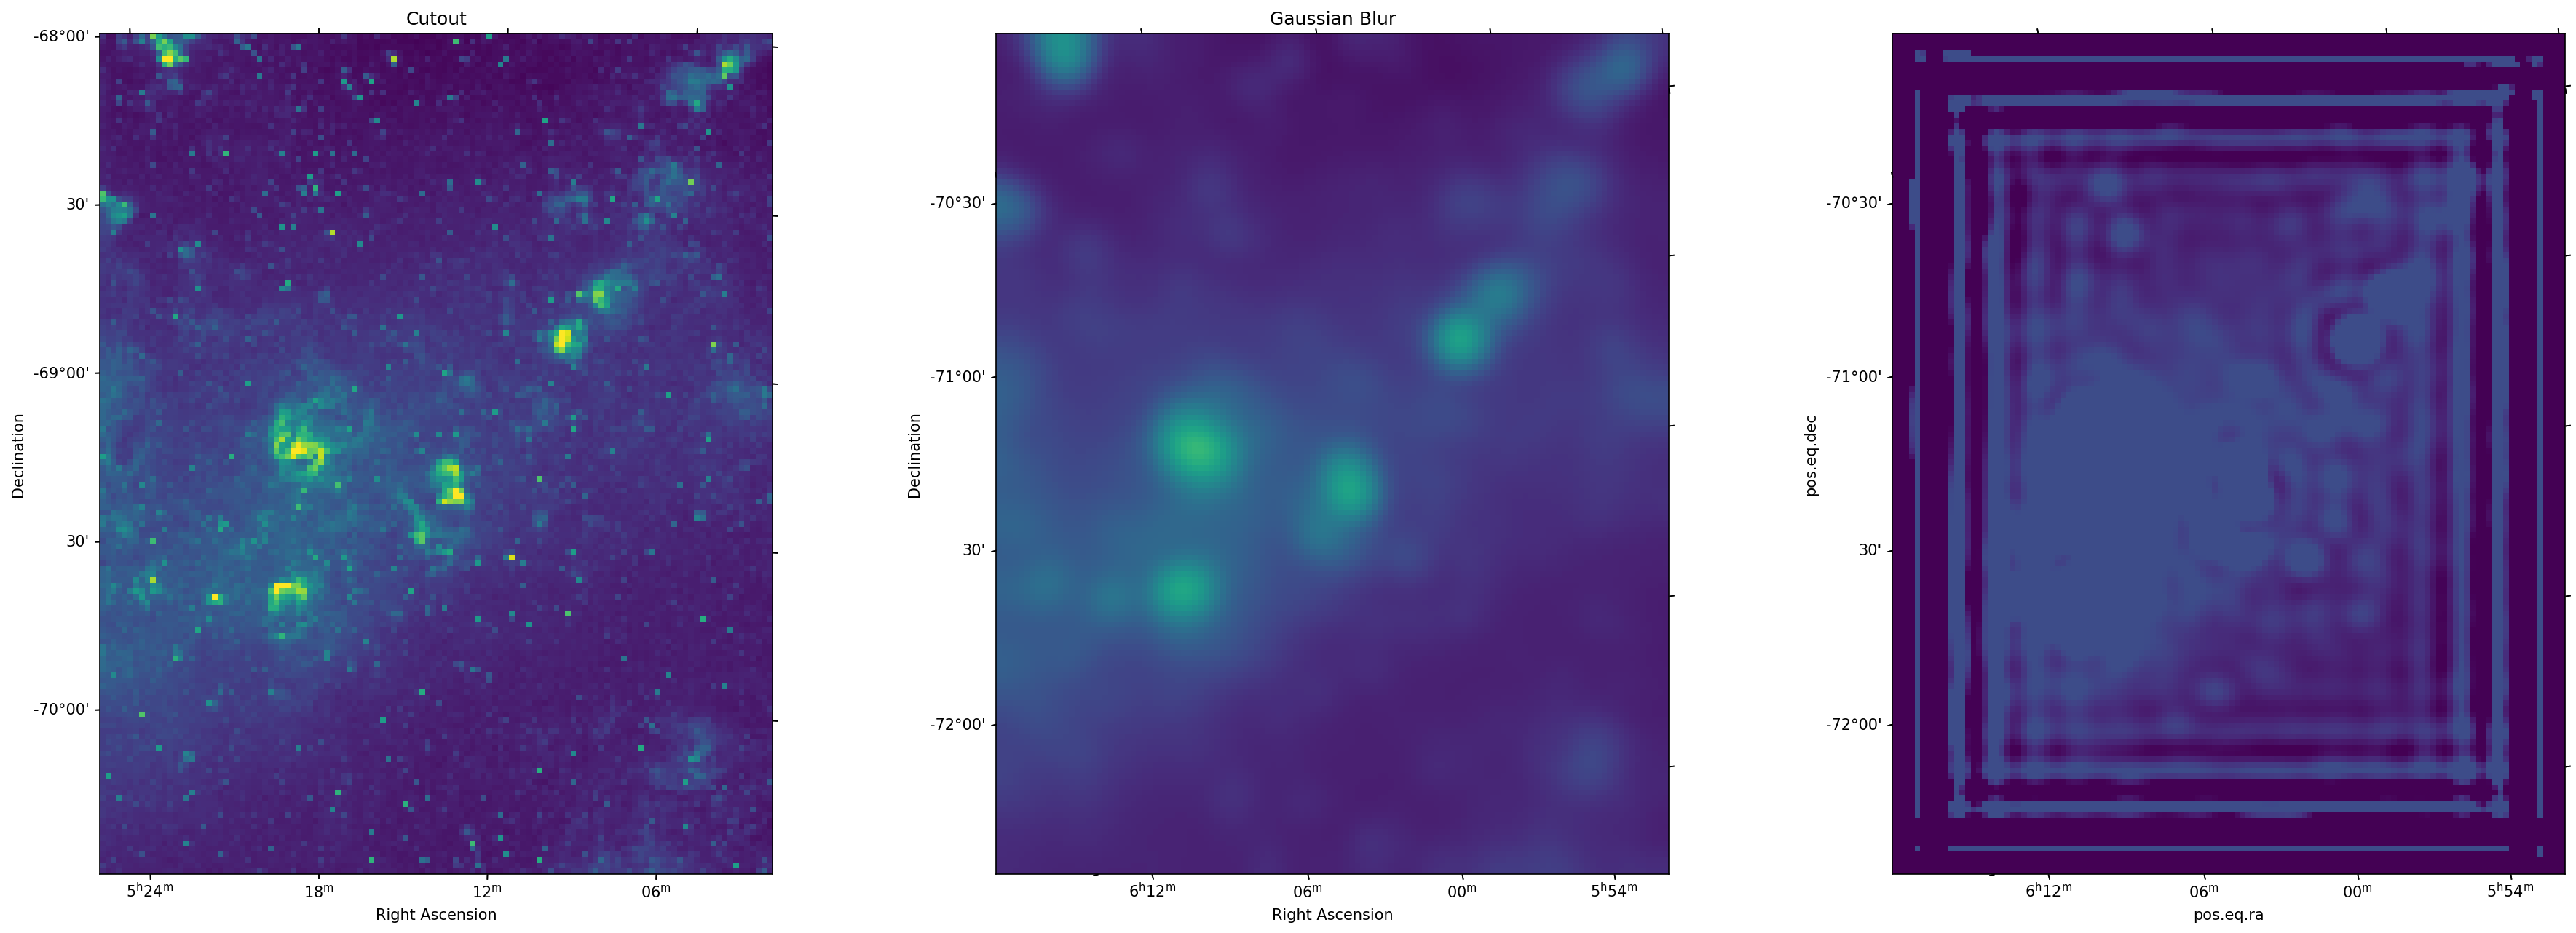

In [8]:
# Code Here
fig = plt.figure(figsize = (30,10),dpi=150)
ax1=fig.add_subplot(131,projection=cut.wcs)
ax1.imshow(np.log10(cut.data+1e-8),origin='lower',vmin=-.3,vmax=1.0)
ax1.set_title("Cutout")
ax1.set_xlabel("Right Ascension")
ax1.set_ylabel("Declination")

ax2 = fig.add_subplot(132,projection=wcs)
ax2.imshow(np.log10(smoothcut+1e-8),origin='lower',vmin=-.3,vmax=1.0)
ax2.set_title("Gaussian Blur")
ax2.set_xlabel("Right Ascension")
ax2.set_ylabel("Declination")


from skimage import restoration

psf = Gaussian2DKernel(width).array

rich = restoration.richardson_lucy(smoothcut,psf,num_iter=1000)
ax3 = fig.add_subplot(133,projection=wcs)
ax3.imshow(np.log10(rich+1e-8),origin='lower',vmin=-.3,vmax=1)
plt.show()

In [9]:
%%capture
# Here we use a script to generate pdf and save it to google drive.

# After executing this cell, you will be asked to link to your GoogleDrive account.
# Then, the pdf will be generated and saved to your GoogleDrive account and you need to go there to download;

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='/content/drive/MyDrive/' '/content/drive/MyDrive/Colab Notebooks/HW10_ASTR310.ipynb' --to pdf

ModuleNotFoundError: No module named 'google.colab'